In [1]:
! wget https://s3.amazonaws.com/assignment-lane-marking-data/data.zip

--2019-04-07 20:28:50--  https://s3.amazonaws.com/assignment-lane-marking-data/data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.109.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.109.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68123858 (65M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  64.97M  16.4MB/s    in 5.2s    

2019-04-07 20:28:56 (12.6 MB/s) - ‘data.zip.1’ saved [68123858/68123858]



In [2]:
! unzip data.zip

Archive:  data.zip
replace binary_lane_bdd/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2

## Define global variables

In [0]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# resize images to this size
img_height, img_width = (256, 256)

# number of gpus to use
num_gpus = 1

## Get path of images

In [0]:
PATH = 'binary_lane_bdd/'
f = Path(PATH)

In [0]:
train_path = sorted(list(f.glob('Images/*')))[1:]
label_path = sorted(list(f.glob('Labels/*')))[1:]

## Load train images and labels

In [0]:
X_data = [np.array(skimage.transform.resize(cv2.imread(str(p)), (img_width, img_height), mode='constant', preserve_range=True), dtype=np.uint8) for p in train_path]
X_data = np.array(X_data)/255

In [13]:
X_data.shape

(501, 256, 256, 3)

In [0]:
Y_data = [np.array(skimage.transform.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE), (img_width, img_height), mode='constant', preserve_range=True), dtype=np.uint8) for p in label_path]
Y_data = np.array(Y_data)/255
Y_data = np.expand_dims(Y_data,axis=3)

In [15]:
Y_data.shape

(501, 256, 256, 1)

## Define evaluation metric

In [0]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


## Define network architechture

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
   
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    
    # encode
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # decode
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
import keras
from keras.optimizers import Adam

# Set some model compile parameters
loss      = bce_dice_loss
metrics   = [mean_iou]

model = get_unet(input_img=Input(shape=(img_height, img_width,3)))

# Use GPUs
if num_gpus > 1:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(optimizer=Adam(lr = 1e-3), loss=loss, metrics=metrics)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Split the data into train and validation

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                   test_size=0.2,
                                                    random_state=seed)

In [23]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((400, 400, 400, 3),
 (101, 400, 400, 3),
 (400, 400, 400, 1),
 (101, 400, 400, 1))

In [23]:
# train the model
model.fit(X_train,
          Y_train, 
          epochs=30, 
          validation_data=[X_test,Y_test], 
          batch_size=16,
          verbose=1)

Train on 400 samples, validate on 101 samples
Epoch 1/30
400/400 [==============================] - 12s 30ms/step - loss: -0.4976 - mean_iou: 0.5487 - val_loss: -0.3423 - val_mean_iou: 0.5491
Epoch 2/30
400/400 [==============================] - 10s 24ms/step - loss: -0.4978 - mean_iou: 0.5496 - val_loss: -0.3264 - val_mean_iou: 0.5500
Epoch 3/30
400/400 [==============================] - 10s 24ms/step - loss: -0.5067 - mean_iou: 0.5504 - val_loss: -0.3290 - val_mean_iou: 0.5508
Epoch 4/30
400/400 [==============================] - 10s 25ms/step - loss: -0.5124 - mean_iou: 0.5513 - val_loss: -0.3466 - val_mean_iou: 0.5517
Epoch 5/30
400/400 [==============================] - 10s 24ms/step - loss: -0.5132 - mean_iou: 0.5520 - val_loss: -0.3434 - val_mean_iou: 0.5525
Epoch 6/30
400/400 [==============================] - 10s 24ms/step - loss: -0.5271 - mean_iou: 0.5528 - val_loss: -0.3466 - val_mean_iou: 0.5533
Epoch 7/30
400/400 [==============================] - 10s 25ms/step - loss: -0

In [24]:
# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape

101/101 [==============================] - 1s 10ms/step


(101, 256, 256, 1)

## Check Predictions

Let's look at some predictions

In [0]:
# some random image ids
iid = [1,24,50,54,60]

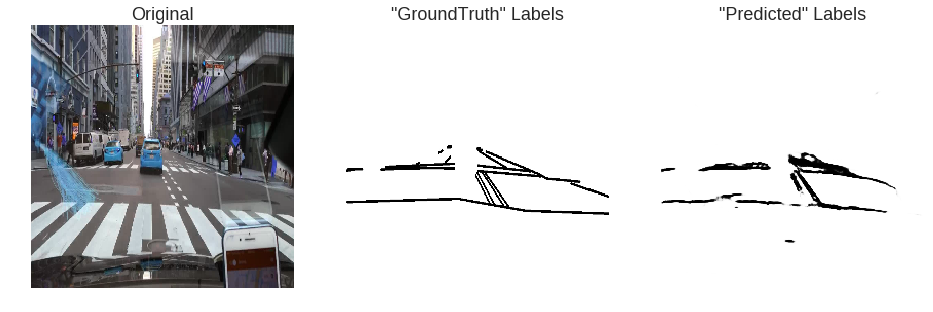

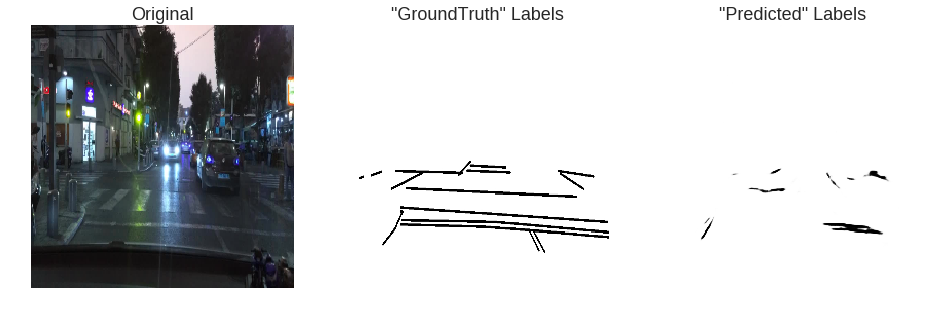

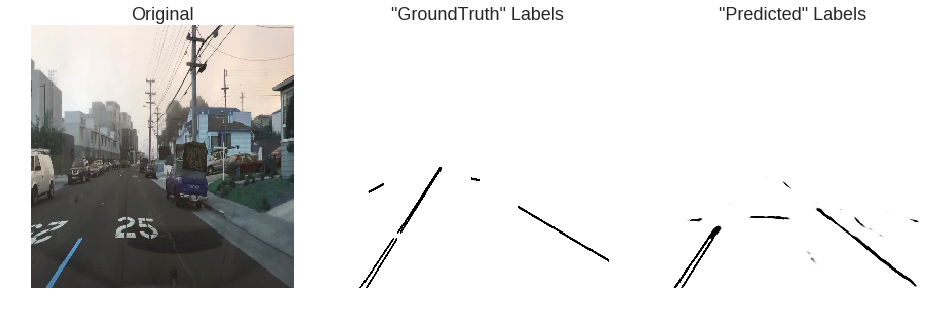

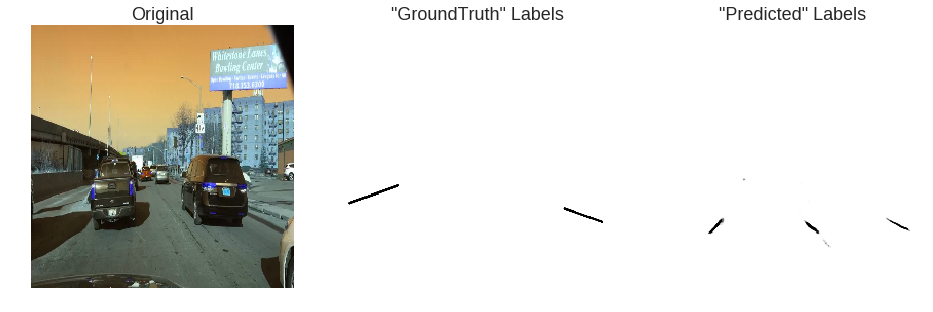

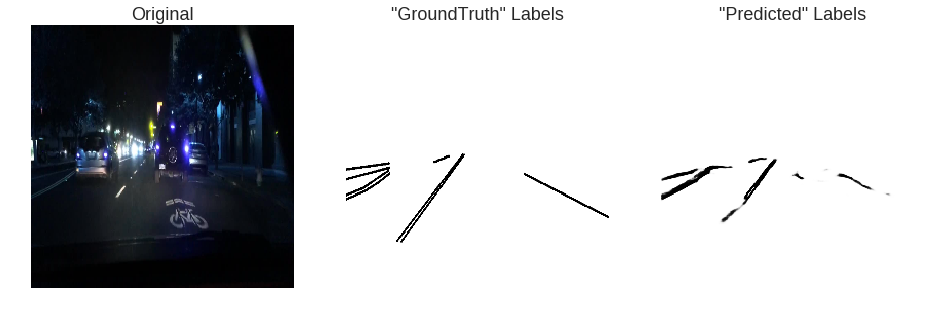

In [39]:
# Plot the objects

for id in iid:

  fig, axes = plt.subplots(1,3, figsize=(16, 9))
  axes[0].imshow(X_test[id])
  axes[1].imshow(Y_test[id].reshape(img_width, img_height))
  axes[2].imshow(Y_hat[id][:,:,0])    
      
  labels = ['Original', '"GroundTruth" Labels', '"Predicted" Labels']
  for ind, ax in enumerate(axes):
      ax.set_title(labels[ind], fontsize=18)
      ax.axis('off')
  